<a href="https://colab.research.google.com/github/wsilveira-splunk/channel_capacity/blob/master/channel_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.integrate import trapz

In [2]:
snr_db = list(range(-8, 31, 1))
snr = list(map(lambda x: pow(10, (x/10)), snr_db))
C_gaussian_ch = list(map(lambda x: 0.5*math.log2(1+x), snr))

p = list(map(lambda x: 0.5*math.erfc(math.sqrt(x/2)), snr))
C_bsc = list(map(lambda x: 1 - (x*math.log2(1/x)+(1-x)*math.log2(1/(1-x))), p))

In [3]:
x_min = -50.0
x_max = 50.0
x_int = np.linspace(x_min, x_max, 10001)

def mutual_info_mpam(m):

  P_mpam = ((len(m)**2)-1)/3
  Pn = list(map(lambda x: P_mpam/x, snr))

  C_mpam = []
  
  for Pn_at_snr in Pn:
    
    y_gaussians = []
    y_gaussians = list(map(lambda x: scipy.stats.norm.pdf(x_int,x,math.sqrt(Pn_at_snr)), m))

    sum_gaussians = []
    for idx in range(len(y_gaussians[0])):

      sum = 0
      for gaussian_idx in range(len(m)):
        sum += y_gaussians[gaussian_idx][idx]

      sum_gaussians.append(sum/len(m))

    h_y_integrand = [] 
    for sum_gaussians_idx in sum_gaussians:
      if sum_gaussians_idx < 10**(-300):
        # avoid zero division and overflow in double variables
        h_y_integrand.append(sum_gaussians_idx)
      else:
        h_y_integrand.append(sum_gaussians_idx * math.log2(1/sum_gaussians_idx))

    mutual_info = trapz(h_y_integrand, x_int) - 0.5*math.log2(2*math.pi*math.e*Pn_at_snr)
    C_mpam.append(mutual_info)

  return C_mpam

m = [-1, 1]
C_2pam = mutual_info_mpam(m)
m = [-3, -1, 1, 3]
C_4pam = mutual_info_mpam(m)
m = [-7, -5, -3, -1, 1, 3, 5, 7]
C_8pam = mutual_info_mpam(m)

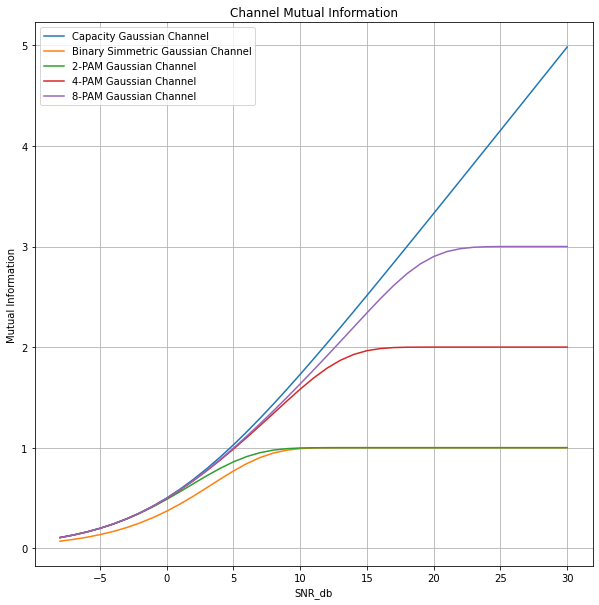

In [4]:
plt.figure(figsize=(10,10)) 
plt.plot(snr_db, C_gaussian_ch, label='Capacity Gaussian Channel') 
plt.plot(snr_db, C_bsc, label='Binary Simmetric Gaussian Channel')
plt.plot(snr_db, C_2pam, label='2-PAM Gaussian Channel')
plt.plot(snr_db, C_4pam, label='4-PAM Gaussian Channel')
plt.plot(snr_db, C_8pam, label='8-PAM Gaussian Channel')
plt.title('Channel Mutual Information')
plt.xlabel('SNR_db')
plt.ylabel('Mutual Information')
plt.legend()
plt.grid(True)
plt.show()